In [2]:
#sys.path.append('PINK2/scripts/')
import time
import numpy
import struct
from matplotlib import pyplot
import subprocess
import os.path
import warnings
import seaborn as sns
import struct
import astropy
import scipy.spatial
import matplotlib.pyplot as plt
#from HiPSfs import HiPSfs
#import astropy.visualization as vis
%matplotlib inline

In [3]:
mapping_file_path="Som6n1.bin"
trained_file_path='som_8_18.bin'
bin_file_path="EN1.bin"
#mapping_file_path='/users/sibusiso/Sibu/pink/sibusiso/work/Som10n1.bin'
#trained_file_path='/users/sibusiso/Sibu/pink/sibusiso/work/Sib/som_10_18.bin'

In [4]:
# Input parameters

# Pixel-size of each cutout
size = [250,250] # of unrotated cut-outs
# Resolution for each cutout in degrees
resolution = 0.0085/60# Note: we already hit bedrock resolution (the highest res. hips-files) so increasing it won't help.
# How many times must a signal surpass the standard dev. to be allowed in?
clip_threshold = 3.0
apply_clipping = True
# Enable scaling?
log_scaling = False
sinh_scaling = False

Max. distance: 23.1522274017334


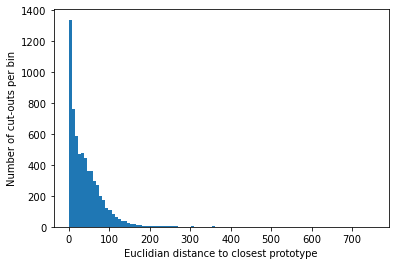

In [5]:
# Unpack SOM mapping
with open(mapping_file_path, 'rb') as inputStream:
    numberOfImages = struct.unpack("i", inputStream.read(4))[0]
    somWidth = struct.unpack("i", inputStream.read(4))[0]
    somHeight = struct.unpack("i", inputStream.read(4))[0]
    somDepth = struct.unpack("i", inputStream.read(4))[0]

    data_map = numpy.ones((numberOfImages, somWidth * somHeight * somDepth))
    for i in range(numberOfImages):
        for t in range(somWidth * somHeight * somDepth):
            data_map[i,t] = struct.unpack_from("f", inputStream.read(4))[0]

# Sort the SOM results for either the outliers or the best-fitting images
extremes = numpy.min(data_map, axis=1) #best fit prototypes
coordinates = numpy.argsort(data_map, axis=1)[:,0] #indices of the minimum value
ids = numpy.argsort(extremes)[::-1]
print('Max. distance:', extremes[-1])

pyplot.hist(extremes, bins=100);
pyplot.xlabel('Euclidian distance to closest prototype');
pyplot.ylabel('Number of cut-outs per bin');

Summed Euclidian distance from this cut-out to its closest prototype: 752.4410400390625 4305


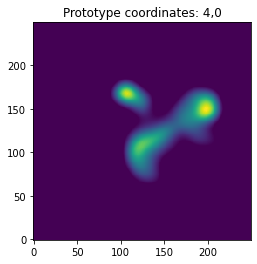

In [6]:
# Can be any number smaller than the total amount of cut-outs/sources in your binary file
number_of_outliers_to_show = 1

def showOutlier(imageFile, number):
    """Unpack image with id=number"""
    inFile = open(imageFile, 'rb')
    numberOfImages, numberOfChannels, width, height = struct.unpack('i' * 4, inFile.read(4 * 4))
    if number > numberOfImages:
        raise Exception('Requested image ID is larger than the number of images.')
    size = width * height
    inFile.seek((number*numberOfChannels + 0) * size*4, 1)
    array = numpy.array(struct.unpack('f' * size, inFile.read(size*4)))
    data = numpy.ndarray([width,height], 'float', array)
    inFile.close()
    return data

# Width of cropped image used in the training
w = size[0]
s = int(numpy.floor(size[0]/numpy.sqrt(2))) 
for id in ids[:number_of_outliers_to_show]:
    # plot 182x182 image
    pyplot.figure()
    image = showOutlier(bin_file_path, id)
    image_clip = numpy.clip(image, clip_threshold*numpy.std(image), 1e10)
    #image = numpy.hstack((image, image_clip))


    pyplot.imshow(image, aspect='equal', interpolation="nearest", origin='lower')#, extent=[-w/2, w/2, -w/2, w/2])

    # plot border around the 128x128 cropped center of the image
    #pyplot.plot( [(w-s)/2,w-(w-s)/2], [(w-s)/2,(w-s)/2],"r")
    #pyplot.plot( [(w-s)/2,(w-s)/2], [(w-s)/2,w-(w-s)/2],"r")
    #pyplot.plot( [w-(w-s)/2,w-(w-s)/2], [(w-s)/2,w-(w-s)/2],"r")
    #pyplot.plot( [(w-s)/2,w-(w-s)/2], [w-(w-s)/2,w-(w-s)/2],"r")
    pyplot.title('Prototype coordinates: ' + str (coordinates[id]%somWidth) + "," + str (int(coordinates[id]/somWidth)))
    print('Summed Euclidian distance from this cut-out to its closest prototype:', extremes[id],id)
    pyplot.show() 

In [7]:
# Unpack trained SOM
with open(trained_file_path, 'rb') as inputStream: 
    #File structure: (SOM_width, SOM_height, SOM_depth, number_of_channels, neuron_width, neuron_height) float
    number_of_channels = struct.unpack("i", inputStream.read(4))[0]
    SOM_width = struct.unpack("i", inputStream.read(4))[0]
    SOM_height = struct.unpack("i", inputStream.read(4))[0]
    SOM_depth = struct.unpack("i", inputStream.read(4))[0]
    neuron_width = struct.unpack("i", inputStream.read(4))[0]
    neuron_height = struct.unpack("i", inputStream.read(4))[0]

    data_som = numpy.ones((SOM_width, SOM_height, SOM_depth, number_of_channels*neuron_width*neuron_height))
    for i in range(SOM_width):
         for ii in range(SOM_height):
            for iii in range(SOM_depth):
                for iv in range(number_of_channels*neuron_width*neuron_height):
                    data_som[i,ii,iii,iv] = struct.unpack_from("f", inputStream.read(4))[0]            

In [8]:
closest = numpy.argsort(data_map, axis=1)[:,0]
farthest = numpy.argsort(data_map, axis=1)[:,-1]

#closest_index = [i for i, som_index in enumerate(closest) if som_index == si]
#len(closest_index)
#closest

In [9]:

r0=[]
r1=[]
r2=[]
r3=[]
r4=[]
r5=[]


for i in range(6):
    x,y,z = 0,i,0
    si = (y*SOM_width)+x
    closest = numpy.argsort(data_map, axis=1)[:,0]
    farthest = numpy.argsort(data_map, axis=1)[:,-1]

    closest_index = [i for i, som_index in enumerate(closest) if som_index == si]
    closest_distances = numpy.min(data_map, axis=1)[closest_index]
    r0.append( closest_distances)
    
    x,y,z = 1,i,0
    si = (y*SOM_width)+x
    closest = numpy.argsort(data_map, axis=1)[:,0]
    farthest = numpy.argsort(data_map, axis=1)[:,-1]

    closest_index = [i for i, som_index in enumerate(closest) if som_index == si]
    closest_distances = numpy.min(data_map, axis=1)[closest_index]
    r1.append( closest_distances)
    
    x,y,z = 2,i,0
    si = (y*SOM_width)+x
    closest = numpy.argsort(data_map, axis=1)[:,0]
    farthest = numpy.argsort(data_map, axis=1)[:,-1]

    closest_index = [i for i, som_index in enumerate(closest) if som_index == si]
    closest_distances = numpy.min(data_map, axis=1)[closest_index]
    r2.append( closest_distances)
    
    x,y,z = 3,i,0
    si = (y*SOM_width)+x
    closest = numpy.argsort(data_map, axis=1)[:,0]
    farthest = numpy.argsort(data_map, axis=1)[:,-1]

    closest_index = [i for i, som_index in enumerate(closest) if som_index == si]
    closest_distances = numpy.min(data_map, axis=1)[closest_index]
    r3.append( closest_distances)
    
    x,y,z = 4,i,0
    si = (y*SOM_width)+x
    closest = numpy.argsort(data_map, axis=1)[:,0]
    farthest = numpy.argsort(data_map, axis=1)[:,-1]

    closest_index = [i for i, som_index in enumerate(closest) if som_index == si]
    closest_distances = numpy.min(data_map, axis=1)[closest_index]
    r4.append( closest_distances)
    
    x,y,z = 5,i,0
    si = (y*SOM_width)+x
    closest = numpy.argsort(data_map, axis=1)[:,0]
    farthest = numpy.argsort(data_map, axis=1)[:,-1]

    closest_index = [i for i, som_index in enumerate(closest) if som_index == si]
    closest_distances = numpy.min(data_map, axis=1)[closest_index]
    r5.append( closest_distances)
    
    
    
    
    
    
    
r0=numpy.array(r0)
r1=numpy.array(r1)
r2=numpy.array(r2)
r3=numpy.array(r3)
r4=numpy.array(r4)
r5=numpy.array(r5)



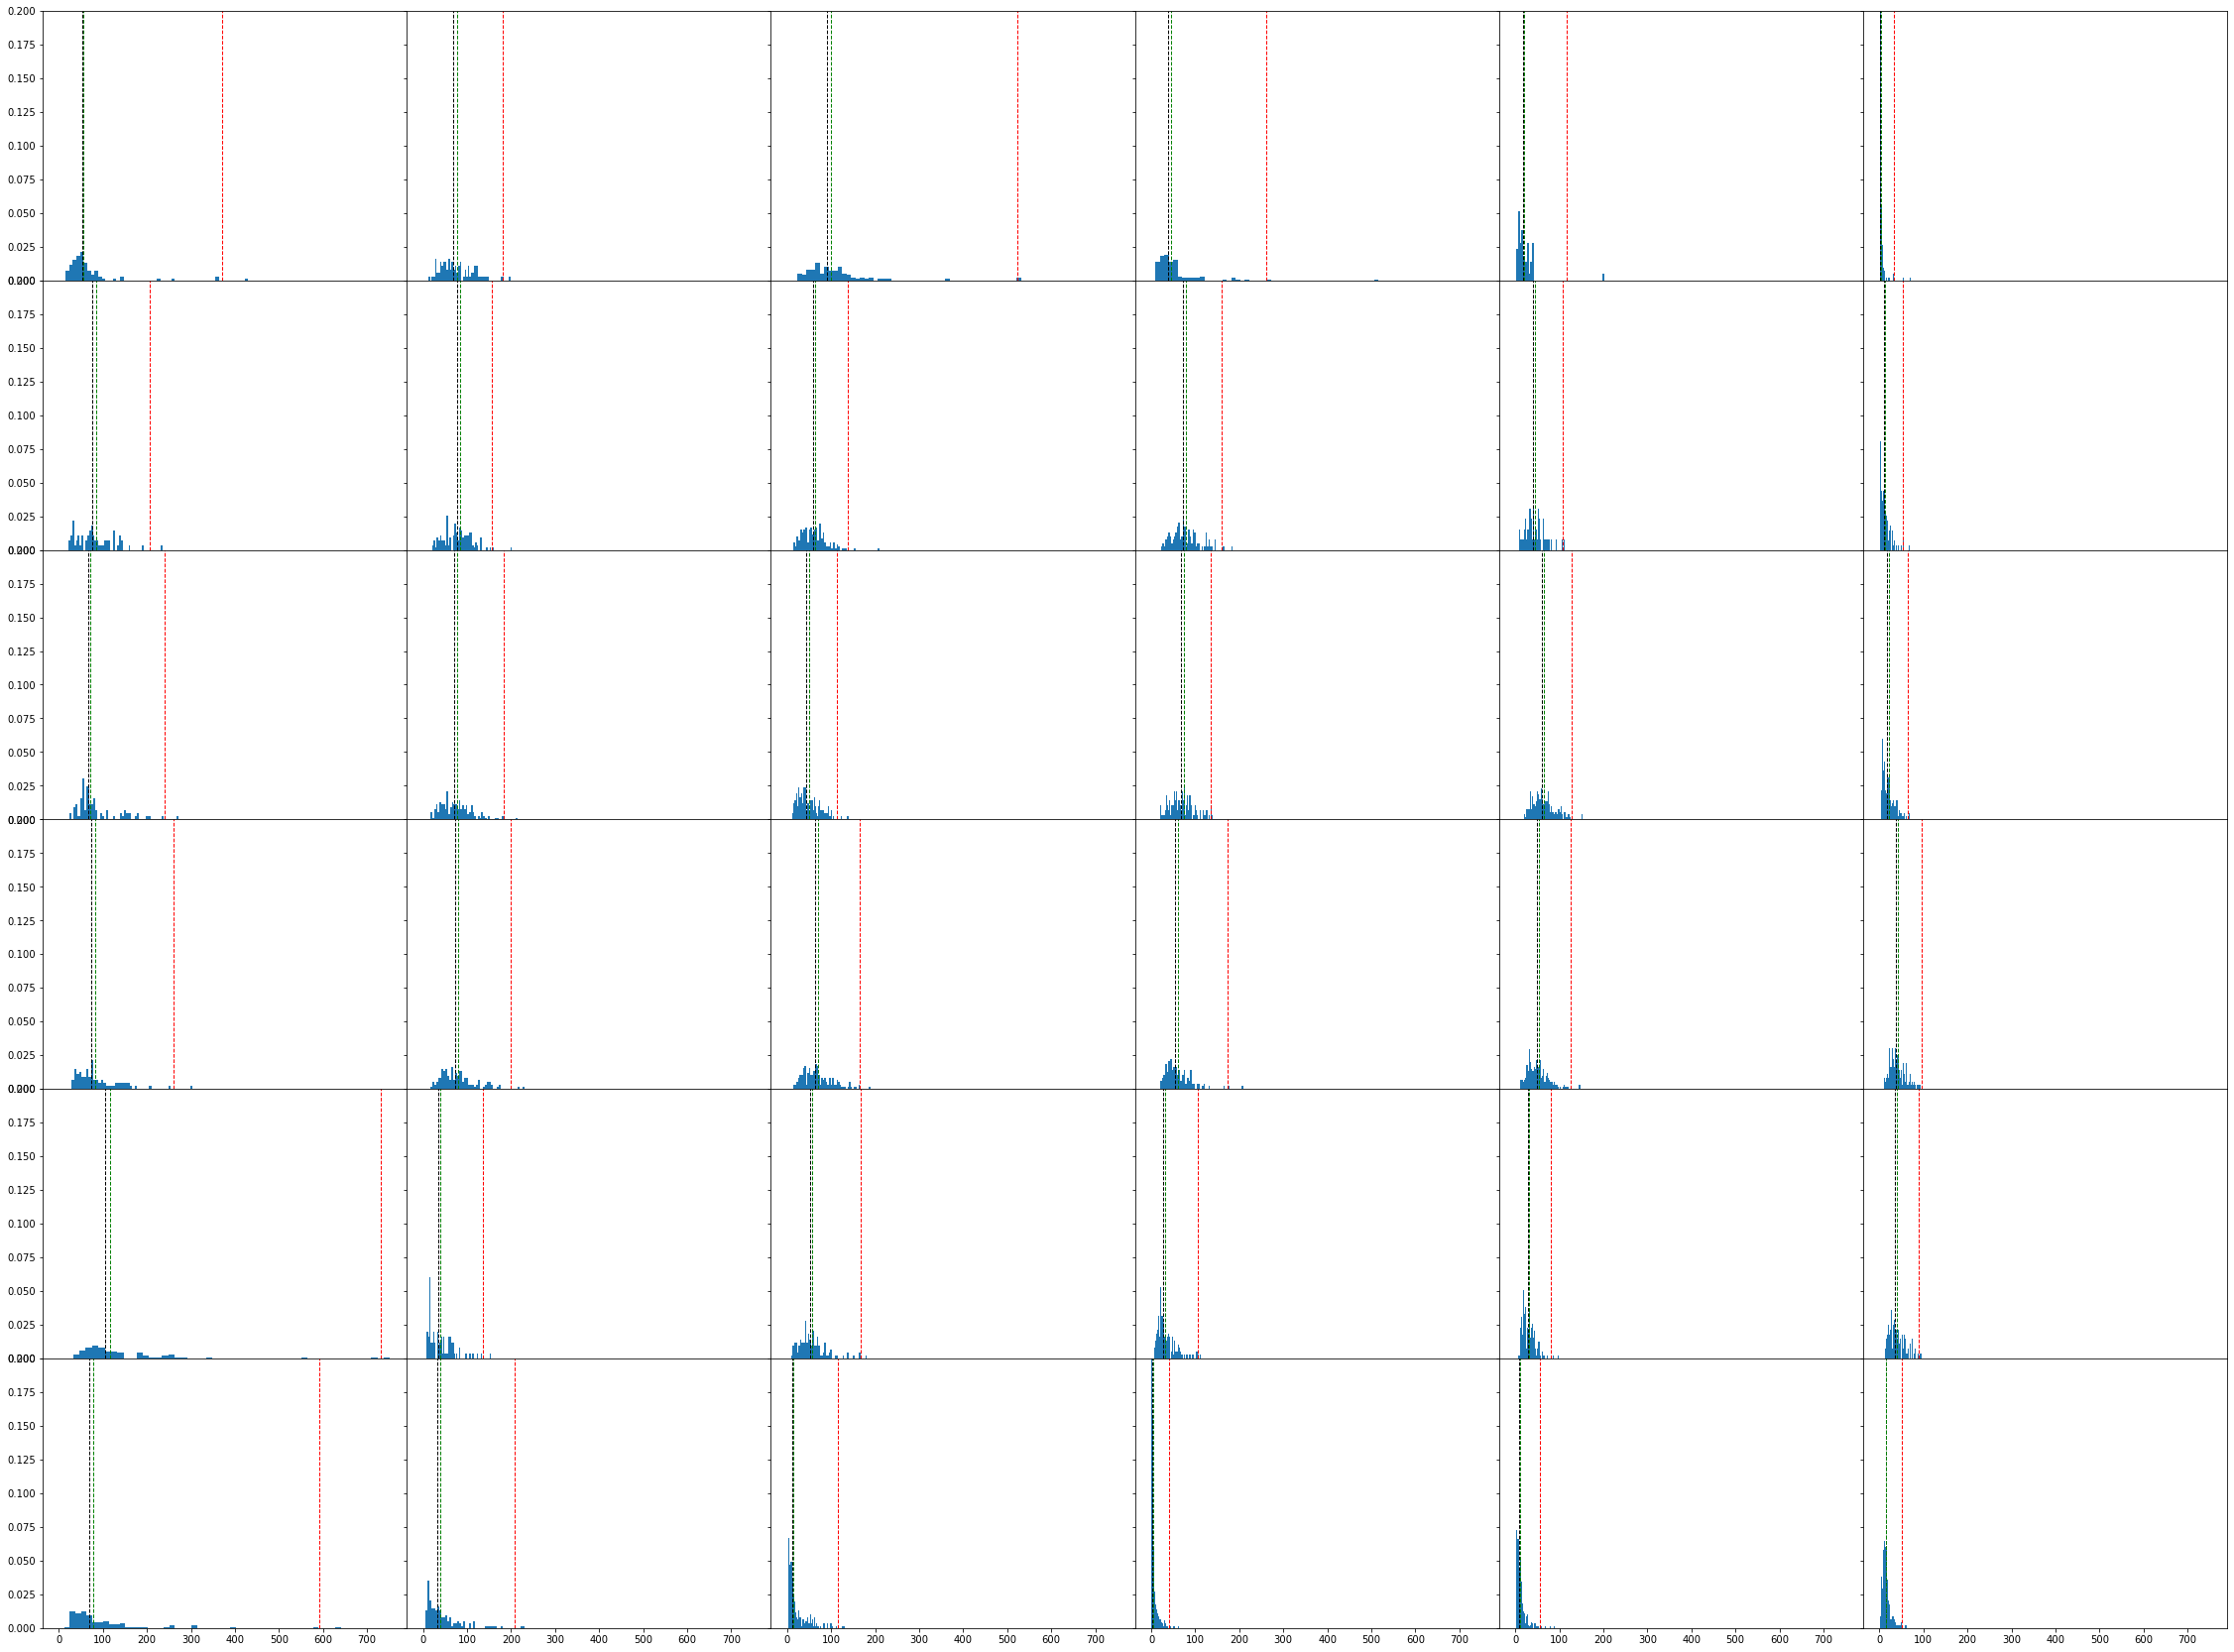

In [10]:
from astropy.stats import median_absolute_deviation
import matplotlib.pyplot as plt
from matplotlib.pyplot import*
from numpy import*


f, ax =subplots(6,6,figsize=(30, 30), sharex=True, sharey=True)
ylim(0, 0.2)
subplots_adjust(left=0.08, right=1.1, wspace=0.0, hspace=0.0)
a=1.5
b=7

for i in  range(6):

    x = r0[i]
    mu = x.mean()
    median = np.median(x)
    amed=median_absolute_deviation(x)
    source=(len(x))
    per=np.percentile(x, 99)
    textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
        r'$\mathrm{mean}=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


    ax[0,i].hist(x, 50, density=True)
    ax[0,i].axvline(median, color='k', linestyle='dashed', linewidth=1, label='median')
    ax[0,i].axvline(per, color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
    ax[0,i].axvline(median+0.3*amed, color='g', linestyle='dashed', linewidth=1,label='99th_percentile')

    # these are matplotlib.patch.Patch properties
   # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    #ax[0,i].text(a, b, textstr, fontsize=13,
            #verticalalignment='top', bbox=props)



    


    x = r1[i]
    mu = x.mean()
    median = np.median(x)
    amed=median_absolute_deviation(x)
    source=(len(x))
    per=np.percentile(x, 99)
    textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
         r'$\mathrm{mean}=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

    ax[1,i].hist(x, 50, density=True)
    ax[1,i].axvline(median, color='k', linestyle='dashed', linewidth=1,label='median')
    ax[1,i].axvline(per, color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
    ax[1,i].axvline(median+0.3*amed, color='g', linestyle='dashed', linewidth=1,label='99th_percentile')

    # these are matplotlib.patch.Patch properties


    # place a text box in upper left in axes coords
    #ax[1,i].text(a, b, textstr, fontsize=13,
            #verticalalignment='top', bbox=props)




    x = r2[i]
    mu = x.mean()
    median = np.median(x)
    amed=median_absolute_deviation(x)
    source=(len(x))
    per=np.percentile(x, 99)
    textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
        r'$\mathrm{mean}=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

    ax[2,i].hist(x, 50, density=True)
    ax[2,i].axvline(median, color='k', linestyle='dashed', linewidth=1,label='median')
    ax[2,i].axvline(per, color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
    ax[2,i].axvline(median+0.3*amed, color='g', linestyle='dashed', linewidth=1,label='99th_percentile')

    # these are matplotlib.patch.Patch properties


    # place a text box in upper left in axes coords
    #ax[2,i].text(a, b, textstr, fontsize=13,
            #verticalalignment='top', bbox=props)




    x = r3[i]
    mu = x.mean()
    median = np.median(x)
    amed=median_absolute_deviation(x)
    source=(len(x))
    per=np.percentile(x, 99)
    textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
        r'$\mathrm{mean}=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

    ax[3,i].hist(x, 50, density=True)
    ax[3,i].axvline(median, color='k', linestyle='dashed', linewidth=1,label='median')
    ax[3,i].axvline(per, color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
    ax[3,i].axvline(median+0.3*amed, color='g', linestyle='dashed', linewidth=1,label='99th_percentile')

    # these are matplotlib.patch.Patch properties


    # place a text box in upper left in axes coords
    #ax[3,i].text(a, b, textstr, fontsize=13,
            #verticalalignment='top', bbox=props)



    x = r4[i]
    mu = x.mean()
    median = np.median(x)
    amed=median_absolute_deviation(x)
    source=(len(x))
    per=np.percentile(x, 99)
    textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
        r'$\mathrm{mean}=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


    ax[4,i].hist(x, 50, density=True)
    ax[4,i].axvline(median, color='k', linestyle='dashed', linewidth=1,label='median')
    ax[4,i].axvline(per, color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
    ax[4,i].axvline(median+0.3*amed, color='g', linestyle='dashed', linewidth=1,label='99th_percentile')

    # these are matplotlib.patch.Patch properties


    # place a text box in upper left in axes coords
    #ax[4,i].text(a, b, textstr, fontsize=13,
            #verticalalignment='top', bbox=props)





    x = r5[i]
    mu = x.mean()
    median = np.median(x)
    amed=median_absolute_deviation(x)
    source=(len(x))
    per=np.percentile(x, 99)
    textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
        r'$\mathrm{mean}=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


    ax[5,i].hist(x, 50, density=True)
    ax[5,i].axvline(median, color='k', linestyle='dashed', linewidth=1,label='median')
    ax[5,i].axvline(per, color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
    ax[5,i].axvline(median+0.3*amed, color='g', linestyle='dashed', linewidth=1,label='99th_percentile')

    # these are matplotlib.patch.Patch properties


    # place a text box in upper left in axes coords
    #ax[5,i].text(a, b, textstr, fontsize=13,
            #verticalalignment='top', bbox=props)




#f.text(0.03, 0.5,'Number of cutouts per bin', fontsize=70, ha='center', va='center', rotation='vertical')

#f.text(0.6, 0.07, 'log(1+ Euclidean Distance to closest prototype)', ha='center')
#f.text(0.02, 0.5, 'Number of cutouts per bin', va='center',  rotation='vertical')
#ax[5,3].set_xlabel('log(1+ Euclidean Distance to closest prototype)', fontsize=70)
#ylim(0, 0.2)
#subplots_adjust(left=0.08, right=1.1, wspace=0.0, hspace=0.0)

#show()

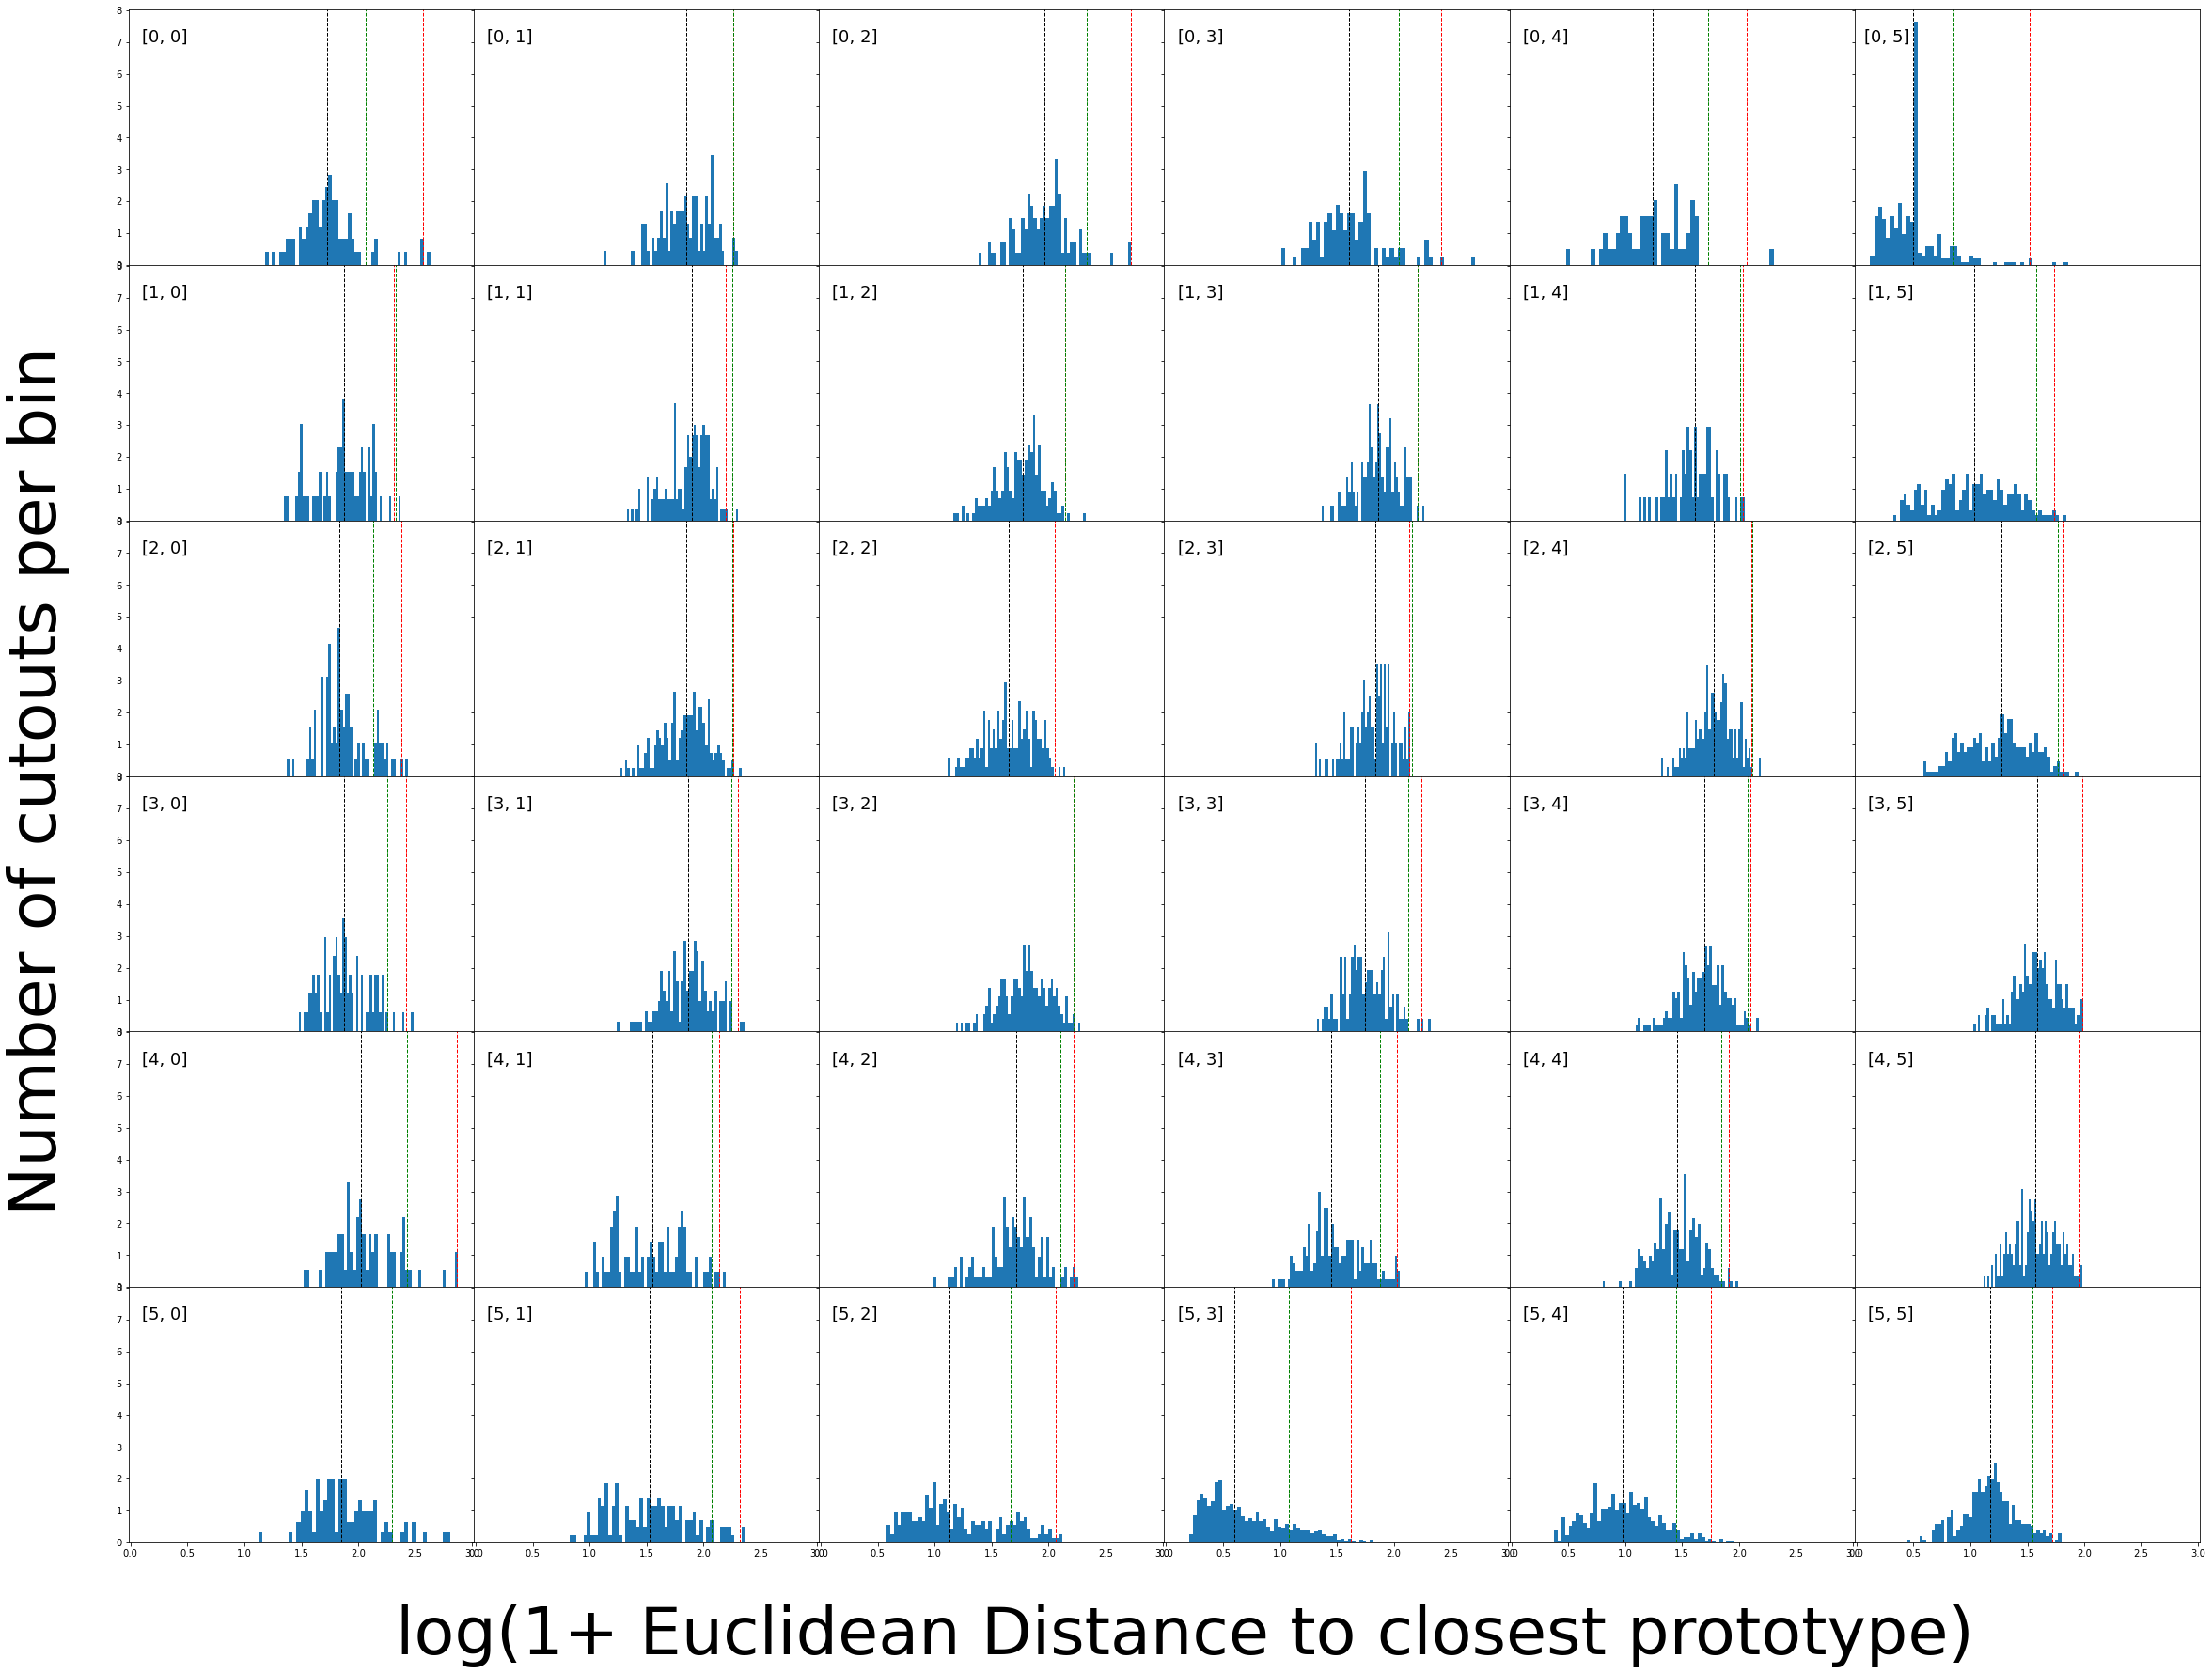

In [11]:
from astropy.stats import median_absolute_deviation
import matplotlib.pyplot as plt
f, ax =subplots(6,6,figsize=(30, 30), sharex=True, sharey=True)
a=1.5
b=7
n=1.4826

x = r0[0]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[0,0].hist(np.log10(1+x), 50, density=True)
ax[0,0].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1, label='median')
ax[0,0].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[0,0].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[0, 0].text(0.3, 7, str([0, 0]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
#ax[0,0].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)



x = r0[1]
mu = x.mean()
median = np.median(x)
sigma = x.std()
amed=n*median_absolute_deviation(x)
source=(len(x))
source=int(source)
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
     r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[0,1].hist(np.log10(1+x), 50,density=True)
ax[0,1].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[0,1].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[0,1].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[0, 1].text(0.3, 7, str([0, 1]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[0,1].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)



x = r0[2]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
     r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[0,2].hist(np.log10(1+x), 50,density=True)
ax[0,2].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[0,2].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[0,2].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[0, 2].text(0.3, 7, str([0, 2]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[0,2].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)



x = r0[3]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
     r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[0,3].hist(np.log10(1+x), 50, density=True)
ax[0,3].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1, label='median')
ax[0,3].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_Percentile')
ax[0,3].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[0, 3].text(0.3, 7, str([0, 3]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[0,3].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r0[4]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
     r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[0,4].hist(np.log10(1+x), 50, density=True)
ax[0,4].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[0,4].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[0,4].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[0, 4].text(0.3, 7, str([0, 4]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[0,4].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)

x = r0[5]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[0,5].hist(np.log10(1+x), 50, density=True)
ax[0,5].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[0,5].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[0,5].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[0, 5].text(0.27, 7, str([0, 5]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[0,5].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r1[0]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
     r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[1,0].hist(np.log10(1+x), 50, density=True)
ax[1,0].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[1,0].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[1,0].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[1, 0].text(0.3, 7, str([1, 0]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[1,0].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r1[1]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[1,1].hist(np.log10(1+x), 50, density=True)
ax[1,1].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1, label='median')
ax[1,1].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[1,1].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[1, 1].text(0.3, 7, str([1, 1]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[1,1].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r1[2]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[1,2].hist(np.log10(1+x), 50, density=True)
ax[1,2].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1, label='median')
ax[1,2].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[1,2].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[1, 2].text(0.3, 7, str([1, 2]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[1,2].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)

x = r1[3]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[1,3].hist(np.log10(1+x), 50, density=True)
ax[1,3].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[1,3].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[1,3].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[1, 3].text(0.3, 7, str([1, 3]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[1,3].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r1[4]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[1,4].hist(np.log10(1+x), 50, density=True)
ax[1,4].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[1,4].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[1,4].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[1, 4].text(0.3, 7, str([1, 4]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[1,4].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r1[5]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[1,5].hist(np.log10(1+x), 50, density=True)
ax[1,5].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1, label='median')
ax[1,5].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[1,5].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[1, 5].text(0.3, 7, str([1, 5]),fontsize=18, ha='center')


# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[1,5].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r2[0]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[2,0].hist(np.log10(1+x), 50, density=True)
ax[2,0].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[2,0].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[2,0].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[2, 0].text(0.3, 7, str([2, 0]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[2,0].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)

x = r2[1]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))



ax[2,1].hist(np.log10(1+x), 50, density=True)
ax[2,1].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[2,1].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[2,1].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[2, 1].text(0.3, 7, str([2, 1]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[2,1].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)




x = r2[2]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[2,2].hist(np.log10(1+x), 50, density=True)
ax[2,2].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1, label='median')
ax[2,2].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[2,2].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[2, 2].text(0.3, 7, str([2, 2]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[2,2].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r2[3]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[2,3].hist(np.log10(1+x), 50, density=True)
ax[2,3].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1, label='median')
ax[2,3].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[2,3].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[2, 3].text(0.3, 7, str([2, 3]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[2,3].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r2[4]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[2,4].hist(np.log10(1+x), 50, density=True)
ax[2,4].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[2,4].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[2,4].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[2, 4].text(0.3, 7, str([2, 4]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[2,4].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)

x = r2[5]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[2,5].hist(np.log10(1+x), 50, density=True)
ax[2,5].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1, label='median')
ax[2,5].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[2,5].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[2, 5].text(0.3, 7, str([2, 5]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[2,5].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r3[0]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[3,0].hist(np.log10(1+x), 50, density=True)
ax[3,0].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[3,0].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[3,0].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[3, 0].text(0.3, 7, str([3, 0]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[3,0].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r3[1]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[3,1].hist(np.log10(1+x), 50, density=True)
ax[3,1].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1, label='median')
ax[3,1].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[3,1].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[3, 1].text(0.3, 7, str([3, 1]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[3,1].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)

x = r3[2]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[3,2].hist(np.log10(1+x), 50, density=True)
ax[3,2].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[3,2].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[3,2].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[3, 2].text(0.3, 7, str([3, 2]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[3,2].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r3[3]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[3,3].hist(np.log10(1+x), 50, density=True)
ax[3,3].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[3,3].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[3,3].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[3, 3].text(0.3, 7, str([3, 3]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[3,3].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r3[4]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[3,4].hist(np.log10(1+x), 50, density=True)
ax[3,4].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[3,4].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[3,4].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[3, 4].text(0.3, 7, str([3, 4]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[3,4].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)

x = r3[5]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[3,5].hist(np.log10(1+x), 50, density=True)
ax[3,5].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[3,5].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[3,5].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[3, 5].text(0.3, 7, str([3, 5]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[3,5].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)



x = r4[0]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[4,0].hist(np.log10(1+x), 50, density=True)
ax[4,0].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[4,0].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[4,0].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[4, 0].text(0.3, 7, str([4, 0]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[4,0].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)

x = r4[1]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))



ax[4,1].hist(np.log10(1+x), 50, density=True)
ax[4,1].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[4,1].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[4,1].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[4, 1].text(0.3, 7, str([4, 1]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[4,1].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)

x = r4[2]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[4,2].hist(np.log10(1+x), 50, density=True)
ax[4,2].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[4,2].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[4,2].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[4, 2].text(0.3, 7, str([4, 2]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[4,2].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r4[3]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[4,3].hist(np.log10(1+x), 50, density=True)
ax[4,3].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[4,3].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[4,3].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[4, 3].text(0.3, 7, str([4, 3]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[4,3].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)

x = r4[4]
mu = x.mean()
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[4,4].hist(np.log10(1+x), 50, density=True)
ax[4,4].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[4,4].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[4,4].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[4, 4].text(0.3, 7, str([4, 4]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[4,4].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r4[5]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[4,5].hist(np.log10(1+x), 50, density=True)
ax[4,5].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[4,5].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[4,5].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[4, 5].text(0.3, 7, str([4, 5]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[4,5].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r5[0]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[5,0].hist(np.log10(1+x), 50, density=True)
ax[5,0].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[5,0].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[5,0].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[5, 0].text(0.3, 7, str([5, 0]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[5,0].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)


x = r5[1]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))



ax[5,1].hist(np.log10(1+x), 50, density=True)
ax[5,1].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[5,1].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[5,1].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[5, 1].text(0.3, 7, str([5, 1]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[5,1].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)

x = r5[2]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[5,2].hist(np.log10(1+x), 50, density=True)
ax[5,2].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[5,2].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[5,2].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[5, 2].text(0.3, 7, str([5, 2]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[5,2].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)

x = r5[3]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))



ax[5,3].hist(np.log10(1+x), 50, density=True)
ax[5,3].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1, label='median')
ax[5,3].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1, label='99th_percentile')
ax[5,3].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[5, 3].text(0.3, 7, str([5, 3]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[5,3].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)

x = r5[4]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


ax[5,4].hist(np.log10(1+x), 50, density=True)
ax[5,4].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[5,4].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[5,4].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[5, 4].text(0.3, 7, str([5, 4]),fontsize=18, ha='center')




# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[5,4].text(a, b, textstr, fontsize=13,
        #verticalalignment='top', bbox=props)

x = r5[5]
mu = x.mean()
median = np.median(x)
amed=n*median_absolute_deviation(x)
source=(len(x))
per=np.percentile(x, 99)
textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (int(source), ),
    r'$\mathrm{mean}=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\mathrm{MAD}=%.2f$' % (amed, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))

ax[5,5].hist(np.log10(1+x), 50, density=True)
ax[5,5].axvline((np.log10(1+median)), color='k', linestyle='dashed', linewidth=1,label='median')
ax[5,5].axvline(np.log10(1+per), color='r', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[5,5].axvline(np.log10(1+(median+3*amed)), color='g', linestyle='dashed', linewidth=1,label='99th_percentile')
ax[5, 5].text(0.3, 7, str([5, 5]),fontsize=18, ha='center')

# these are matplotlib.patch.Patch properties


# place a text box in upper left in axes coords
#ax[5,5].text(a, b, textstr, fontsize=15,
        #verticalalignment='top', bbox=props)

#f.text(0.03, 0.5,'Number of cutouts per bin', fontsize=70, ha='center', va='center', rotation='vertical')

f.text(0.6, 0.07, 'log(1+ Euclidean Distance to closest prototype)',fontsize=70, ha='center')
f.text(0.02, 0.5, 'Number of cutouts per bin', va='center',fontsize=70,  rotation='vertical')
#ax[5,3].set_xlabel('log(1+ Euclidean Distance to closest prototype)', fontsize=70)
#ylim(0, 10)
subplots_adjust(left=0.08, right=1.1, wspace=0.0, hspace=0.0)

show()

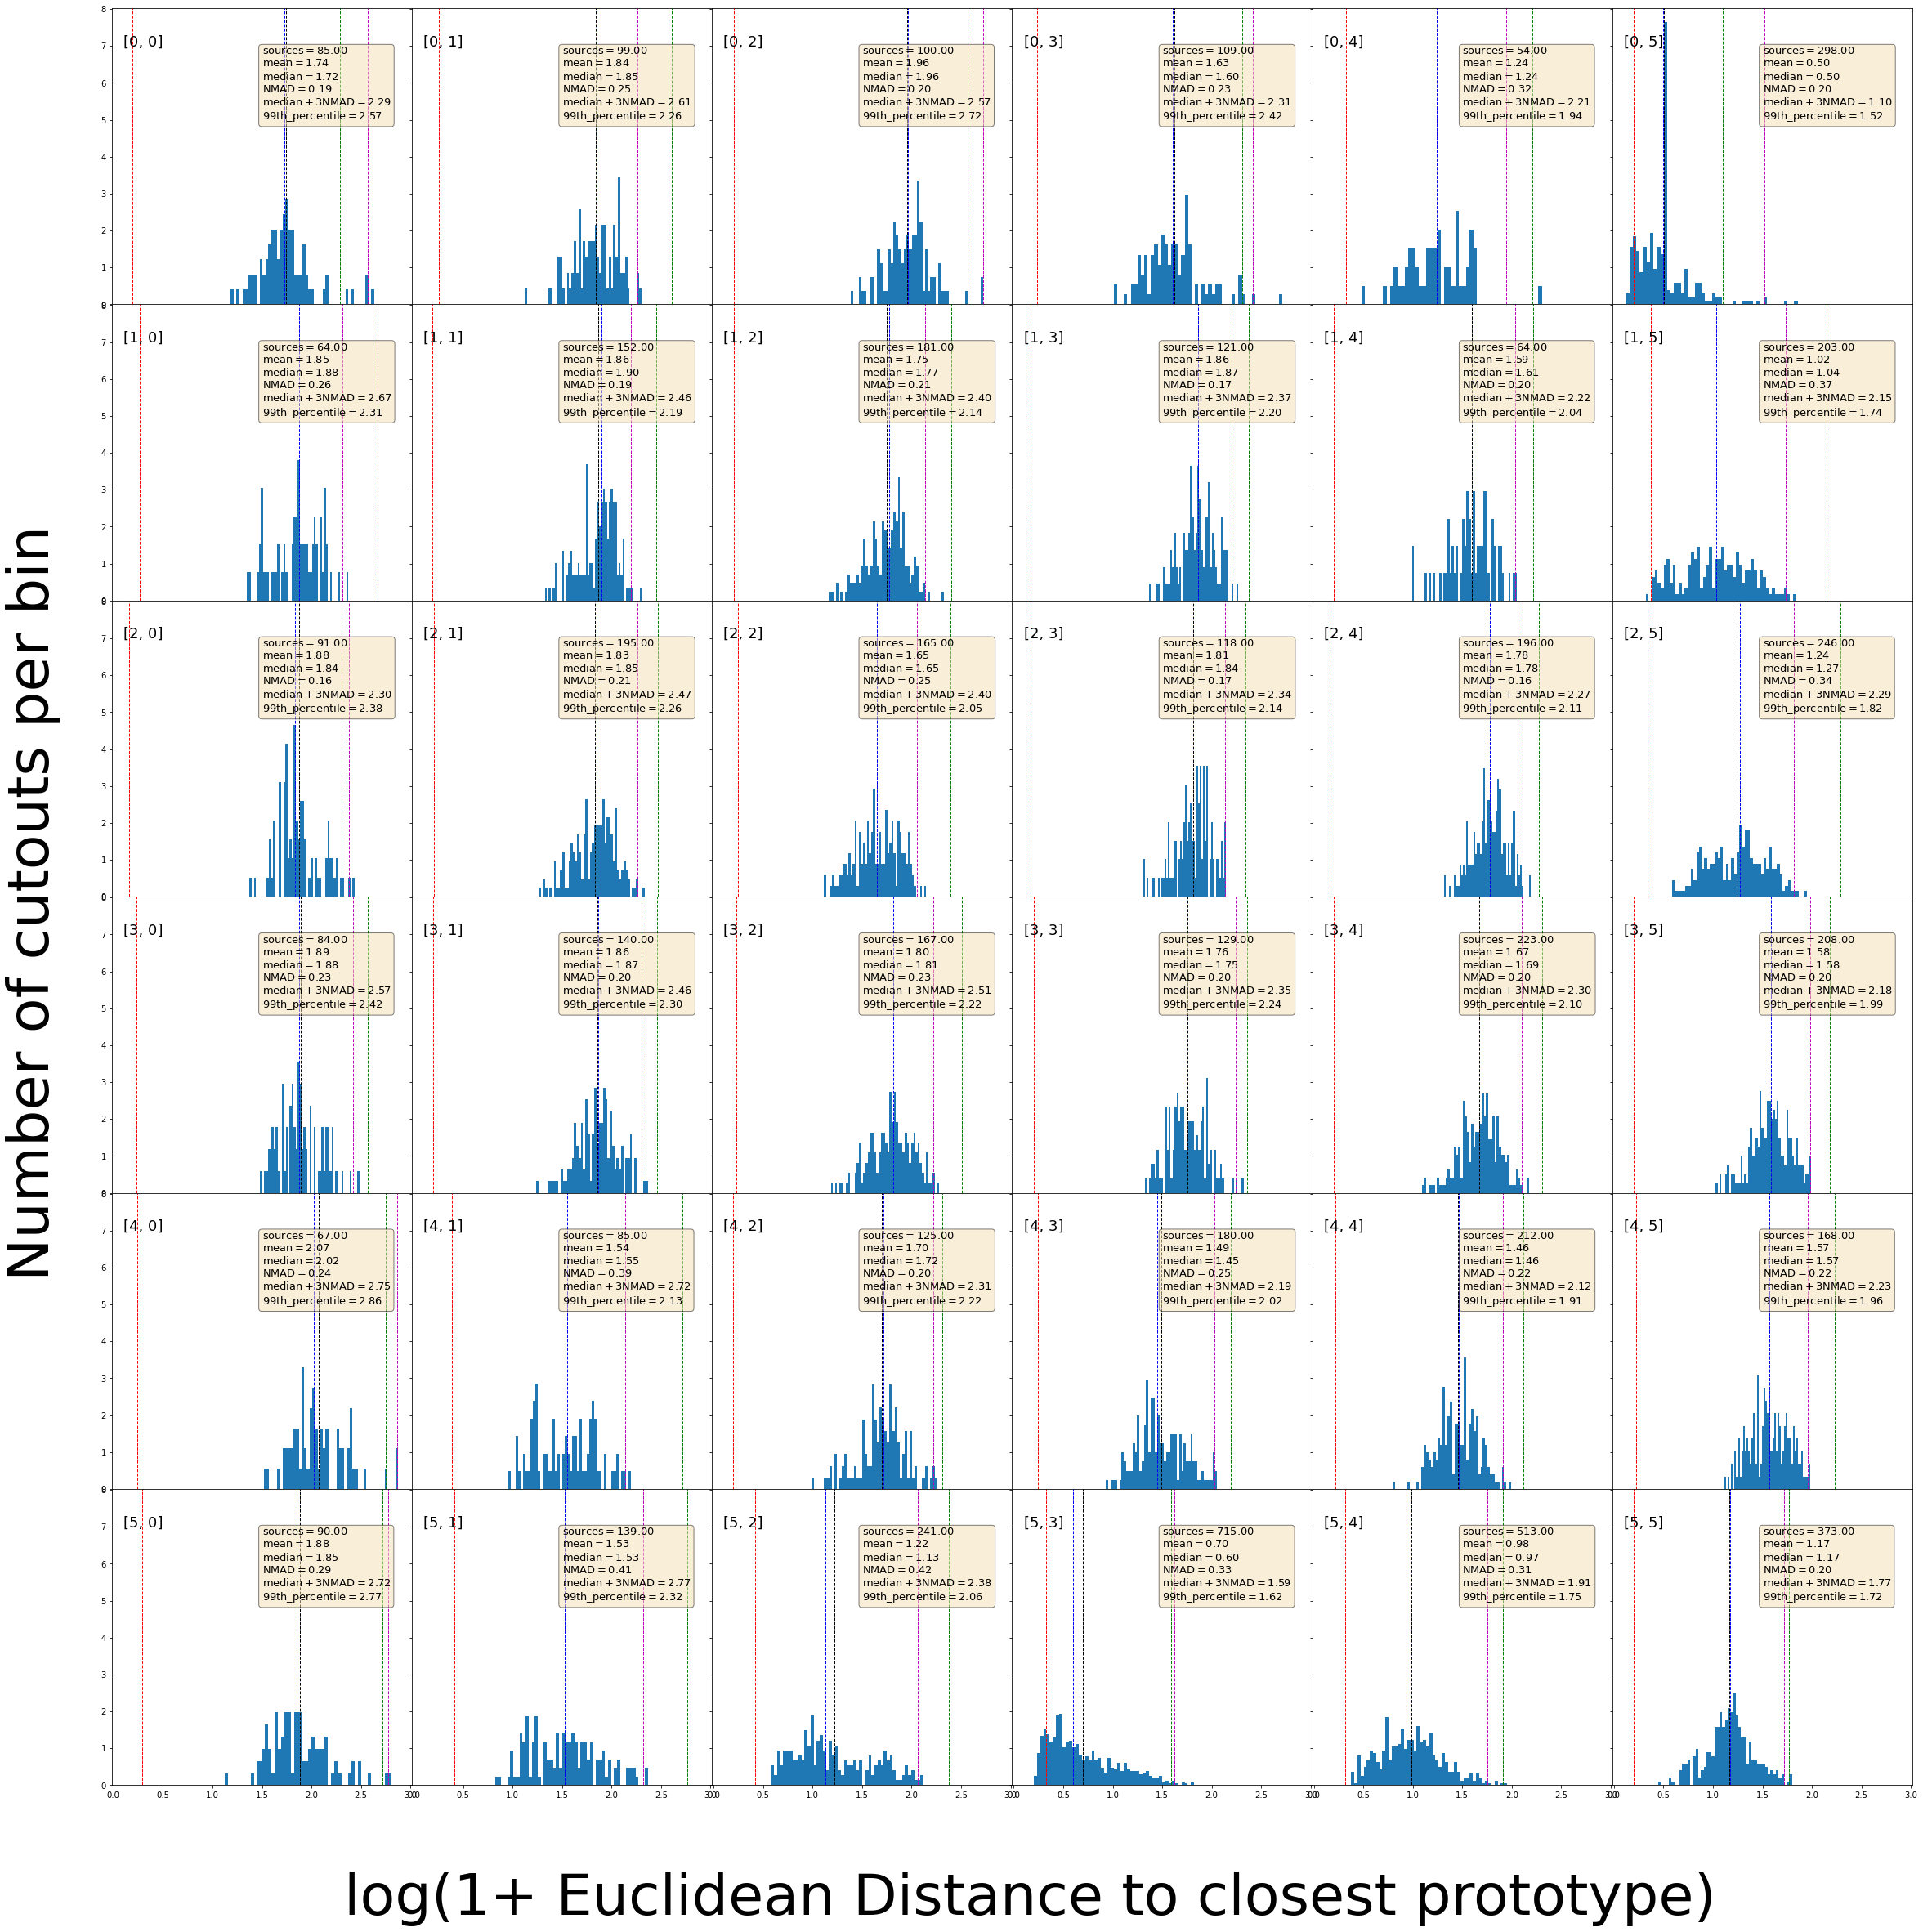

In [12]:
from astropy.stats import median_absolute_deviation
import matplotlib.pyplot as plt
f, ax =subplots(6,6,figsize=(30, 40), sharex=True, sharey=True)
subplots_adjust(left=0.08, right=1.1, wspace=0.0, hspace=0.0)
a=1.5
b=7
n=1.4826
f.text(0.6, 0.07, 'log(1+ Euclidean Distance to closest prototype)',fontsize=70, ha='center')
f.text(0.02, 0.5, 'Number of cutouts per bin', va='center',fontsize=70,  rotation='vertical')
#ax[5,3].set_xlabel('log(1+ Euclidean Distance to closest prototype)', fontsize=70)
#ylim(0, 10)

subplots_adjust(left=0.08, right=1.1, wspace=0.0, hspace=0.0)

for i in  range(6):


    x = np.log10(1+r0[i])
    mu = np.mean(x)
    median = np.median(x)
    amed=n*median_absolute_deviation(x)
    source=(len(x))
    per=np.percentile(x, 99)
    nm = median+3*amed
    textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
        r'$\mathrm{mean}=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\mathrm{NMAD}=%.2f$' % (amed, ),r'$\mathrm{median+3NMAD}=%.2f$' % (nm, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


    ax[0,i].hist(x, 50, density=True)
    ax[0,i].axvline(mu, color='k', linestyle='dashed', linewidth=1,label='mean')
    ax[0,i].axvline(median, color='b', linestyle='dashed', linewidth=1,label='median')
    ax[0,i].axvline(amed, color='r', linestyle='dashed', linewidth=1,label='NMAD')
    ax[0,i].axvline(median+3*amed, color='g', linestyle='dashed', linewidth=1,label='median+3NMAD')
    ax[0,i].axvline(per, color='m', linestyle='dashed', linewidth=1,label='99th_percentile')
    ax[0, i].text(0.3, 7, str([0, i]),fontsize=18, ha='center')

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax[0,i].text(a, b, textstr, fontsize=13,
            verticalalignment='top', bbox=props)






    x = np.log10(1+r1[i])
    mu = x.mean()
    median = np.median(x)
    amed=n*median_absolute_deviation(x)
    source=(len(x))
    per=np.percentile(x, 99)
    nm = median+3*amed
    textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
        r'$\mathrm{mean}=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\mathrm{NMAD}=%.2f$' % (amed, ),r'$\mathrm{median+3NMAD}=%.2f$' % (nm, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


    ax[1,i].hist(x, 50, density=True)
    ax[1,i].axvline(mu, color='k', linestyle='dashed', linewidth=1,label='mean')
    ax[1,i].axvline(median, color='b', linestyle='dashed', linewidth=1,label='median')
    ax[1,i].axvline(amed, color='r', linestyle='dashed', linewidth=1,label='NMAD')
    ax[1,i].axvline(median+3*amed, color='g', linestyle='dashed', linewidth=1,label='median+3NMAD')
    ax[1,i].axvline(per, color='m', linestyle='dashed', linewidth=1,label='99th_percentile')
    ax[1, i].text(0.3, 7, str([1, i]),fontsize=18, ha='center')

    # these are matplotlib.patch.Patch properties


    # place a text box in upper left in axes coords
    ax[1,i].text(a, b, textstr, fontsize=13,
            verticalalignment='top', bbox=props)




    x = np.log10(1+r2[i])
    mu = x.mean()
    median = np.median(x)
    amed=n*median_absolute_deviation(x)
    source=(len(x))
    per=np.percentile(x, 99)
    nm = median+3*amed
    textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
        r'$\mathrm{mean}=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\mathrm{NMAD}=%.2f$' % (amed, ),r'$\mathrm{median+3NMAD}=%.2f$' % (nm, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


    ax[2,i].hist(x, 50, density=True)
    ax[2,i].axvline(mu, color='k', linestyle='dashed', linewidth=1,label='mean')
    ax[2,i].axvline(median, color='b', linestyle='dashed', linewidth=1,label='median')
    ax[2,i].axvline(amed, color='r', linestyle='dashed', linewidth=1,label='NMAD')
    ax[2,i].axvline(median+3*amed, color='g', linestyle='dashed', linewidth=1,label='median+3NMAD')
    ax[2,i].axvline(per, color='m', linestyle='dashed', linewidth=1,label='99th_percentile')
    ax[2, i].text(0.3, 7, str([2, i]),fontsize=18, ha='center')

    # place a text box in upper left in axes coords
    ax[2,i].text(a, b, textstr, fontsize=13,
            verticalalignment='top', bbox=props)


    
    
    x = np.log10(1+r3[i])
    mu = x.mean()
    median = np.median(x)
    amed=n*median_absolute_deviation(x)
    source=(len(x))
    per=np.percentile(x, 99)
    nm = median+3*amed
    textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
        r'$\mathrm{mean}=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\mathrm{NMAD}=%.2f$' % (amed, ),r'$\mathrm{median+3NMAD}=%.2f$' % (nm, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


    ax[3,i].hist(x, 50, density=True)
    ax[3,i].axvline(mu, color='k', linestyle='dashed', linewidth=1,label='mean')
    ax[3,i].axvline(median, color='b', linestyle='dashed', linewidth=1,label='median')
    ax[3,i].axvline(amed, color='r', linestyle='dashed', linewidth=1,label='NMAD')
    ax[3,i].axvline(median+3*amed, color='g', linestyle='dashed', linewidth=1,label='median+3NMAD')
    ax[3,i].axvline(per, color='m', linestyle='dashed', linewidth=1,label='99th_percentile')
    ax[3, i].text(0.3, 7, str([3, i]),fontsize=18, ha='center')

    # these are matplotlib.patch.Patch properties


    # place a text box in upper left in axes coords
    ax[3,i].text(a, b, textstr, fontsize=13,
            verticalalignment='top', bbox=props)







    x =np.log10(1+r4[i])
    mu = x.mean()
    median = np.median(x)
    amed=n*median_absolute_deviation(x)
    source=(len(x))
    per=np.percentile(x, 99)
    nm = median+3*amed
    textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
        r'$\mathrm{mean}=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\mathrm{NMAD}=%.2f$' % (amed, ),r'$\mathrm{median+3NMAD}=%.2f$' % (nm, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


    ax[4,i].hist(x, 50, density=True)
    ax[4,i].axvline(mu, color='k', linestyle='dashed', linewidth=1,label='mean')
    ax[4,i].axvline(median, color='b', linestyle='dashed', linewidth=1,label='median')
    ax[4,i].axvline(amed, color='r', linestyle='dashed', linewidth=1,label='NMAD')
    ax[4,i].axvline(median+3*amed, color='g', linestyle='dashed', linewidth=1,label='median+3NMAD')
    ax[4,i].axvline(per, color='m', linestyle='dashed', linewidth=1,label='99th_percentile')
    ax[4, i].text(0.3, 7, str([4, i]),fontsize=18, ha='center')


    # these are matplotlib.patch.Patch properties


    # place a text box in upper left in axes coords
    ax[4,i].text(a, b, textstr, fontsize=13,
            verticalalignment='top', bbox=props)




    x =np.log10(1+r5[i])
    mu = np.mean(x)
    median = np.median(x)
    amed=n*median_absolute_deviation(x)
    source=(len(x))
    per=np.percentile(x, 99)
    
    nm = median+3*amed
    textstr = '\n'.join((r'$\mathrm{sources}=%.2f$' % (source, ),
        r'$\mathrm{mean}=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\mathrm{NMAD}=%.2f$' % (amed, ),r'$\mathrm{median+3NMAD}=%.2f$' % (nm, ),(r'$\mathrm{99th\_percentile}=%.2f$' % (per, ))))


    ax[5,i].hist(x, 50, density=True)
    ax[5,i].axvline(mu, color='k', linestyle='dashed', linewidth=1,label='mean')
    ax[5,i].axvline(median, color='b', linestyle='dashed', linewidth=1,label='median')
    ax[5,i].axvline(amed, color='r', linestyle='dashed', linewidth=1,label='NMAD')
    ax[5,i].axvline(median+3*amed, color='g', linestyle='dashed', linewidth=1,label='median+3NMAD')
    ax[5,i].axvline(per, color='m', linestyle='dashed', linewidth=1,label='99th_percentile')

    ax[5, i].text(0.3, 7, str([5, i]),fontsize=18, ha='center')

    # these are matplotlib.patch.Patch properties


    # place a text box in upper left in axes coords
    ax[5,i].text(a, b, textstr, fontsize=13,
            verticalalignment='top', bbox=props)




In [13]:
#Plotting Number of sources

mr0=[]
mr1=[]
mr2=[]
mr3=[]
mr4=[]
mr5=[]
for i in range(len(r0)):
    
    a=len(r0[i])
    b=len(r1[i])
    c=len(r2[i])
    d=len(r3[i])
    e=len(r4[i])
    f=len(r5[i])
    mr0.append(a)
    mr1.append(b)
    mr2.append(c)
    mr3.append(d)
    mr4.append(e)
    mr5.append(f)
    

r6=np.array([mr0, mr1, mr2, mr3, mr4, mr5])
r6


array([[ 85,  99, 100, 109,  54, 298],
       [ 64, 152, 181, 121,  64, 203],
       [ 91, 195, 165, 118, 196, 246],
       [ 84, 140, 167, 129, 223, 208],
       [ 67,  85, 125, 180, 212, 168],
       [ 90, 139, 241, 715, 513, 373]])

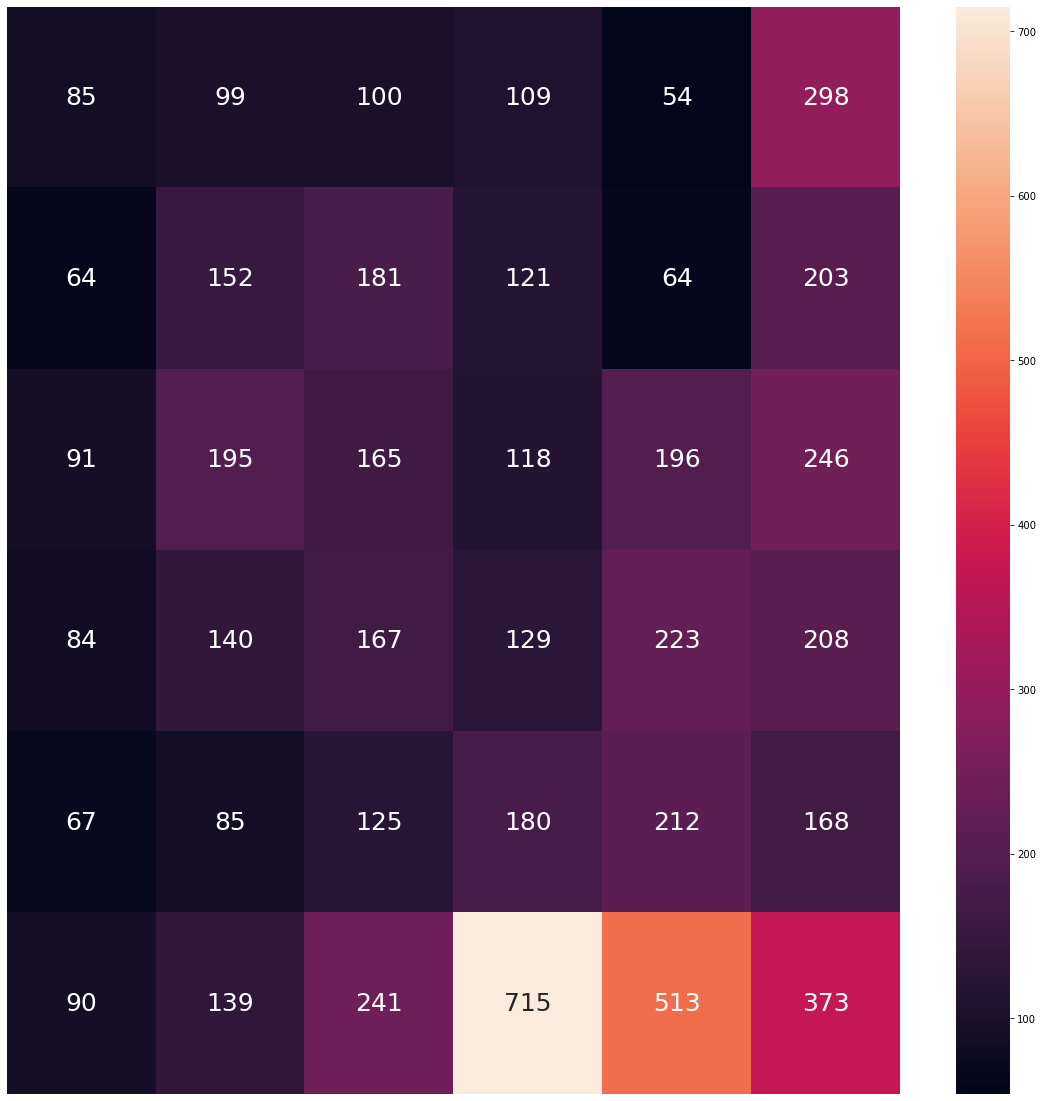

In [14]:
#Plotting the  number of sources
pyplot.figure(figsize=(20, 20))
import seaborn as sn

map = sn.heatmap(r6,annot=True,fmt="d", annot_kws={'size':25},xticklabels=False,
                yticklabels=False )
plt.show()

In [34]:
#Plotting the mean
mr0=[]
mr1=[]
mr2=[]
mr3=[]
mr4=[]
mr5=[]
for i in range(len(r0)):
    
    a=np.mean(np.log10(1+r0[i]))
    b=np.mean(np.log10(1+r1[i]))
    c=np.mean(np.log10(1+r2[i]))
    d=np.mean(np.log10(1+r3[i]))
    e=np.mean(np.log10(1+r4[i]))
    f=np.mean(np.log10(1+r5[i]))
    mr0.append(a)
    mr1.append(b)
    mr2.append(c)
    mr3.append(d)
    mr4.append(e)
    mr5.append(f)
    

r6=np.array([mr0, mr1, mr2, mr3, mr4, mr5])
r6

array([[1.73966545, 1.83848482, 1.95648072, 1.62611709, 1.24107607,
        0.50209527],
       [1.8525244 , 1.86150095, 1.74699828, 1.85945878, 1.59438067,
        1.02023435],
       [1.8763834 , 1.83013804, 1.64950697, 1.81177357, 1.78137078,
        1.23721045],
       [1.88819669, 1.85697311, 1.79699173, 1.7550282 , 1.67381145,
        1.58312659],
       [2.0699914 , 1.53664124, 1.69711177, 1.49194445, 1.45924339,
        1.57202172],
       [1.88285301, 1.52847079, 1.21768061, 0.69652888, 0.98401338,
        1.16778075]])

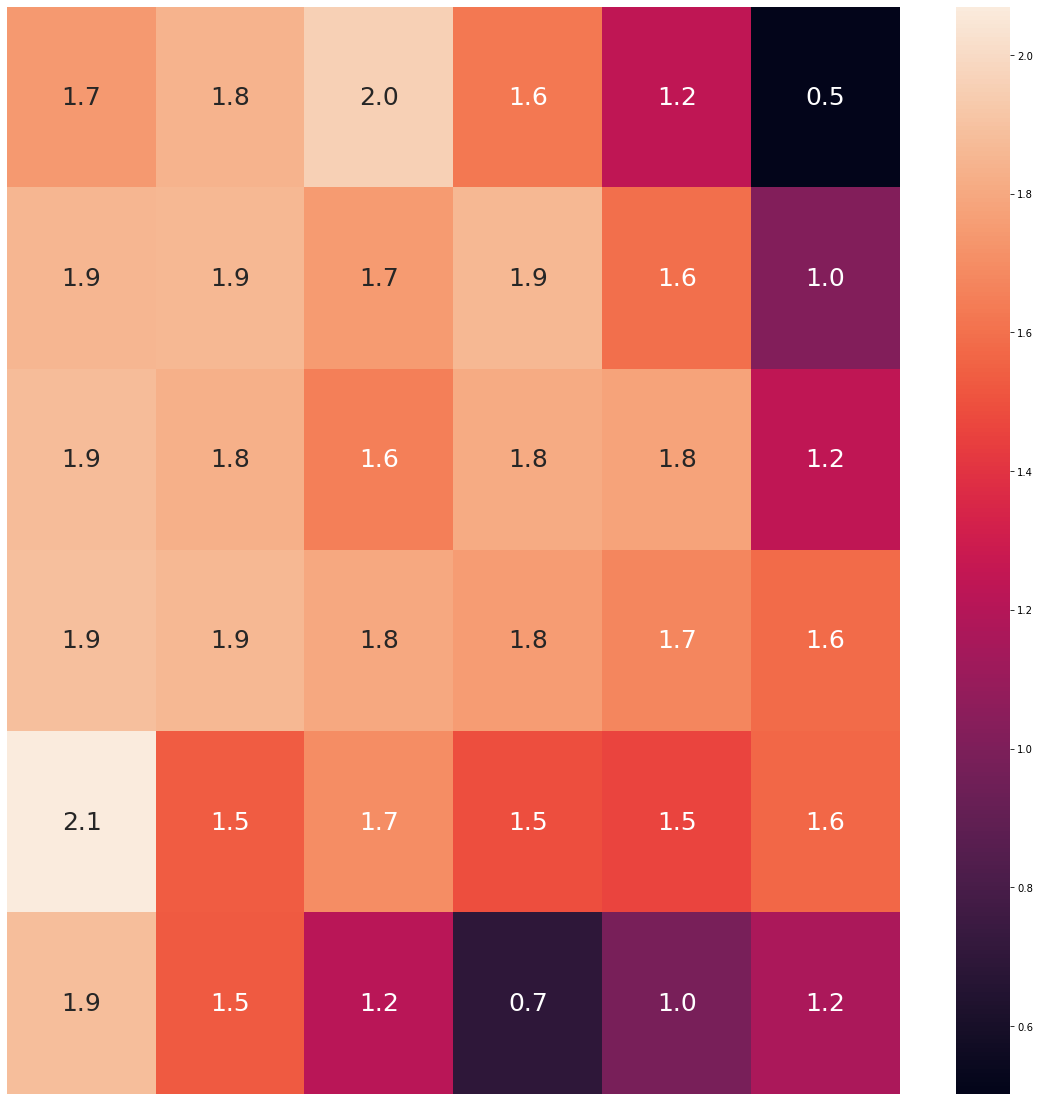

In [35]:
#Plotting the mean
pyplot.figure(figsize=(20, 20))
import seaborn as sn

map = sn.heatmap(r6,annot=True,fmt=".1f", annot_kws={'size':25}, xticklabels=False,
                yticklabels=False)
plt.show()

In [36]:
#Plotting the median

mr0=[]
mr1=[]
mr2=[]
mr3=[]
mr4=[]
mr5=[]
for i in range(len(r0)):
    
    a=np.log10(1+np.median(r0[i]))
    b=np.log10(1+np.median(r1[i]))
    c=np.log10(1+np.median(r2[i]))
    d=np.log10(1+np.median(r3[i]))
    e=np.log10(1+np.median(r4[i]))
    f=np.log10(1+np.median(r5[i]))
    mr0.append(a)
    mr1.append(b)
    mr2.append(c)
    mr3.append(d)
    mr4.append(e)
    mr5.append(f)
    

r6=np.array([mr0, mr1, mr2, mr3, mr4, mr5])
r6



array([[1.7233849 , 1.84701449, 1.96461631, 1.60363378, 1.23958528,
        0.50075592],
       [1.87789824, 1.89896467, 1.77406589, 1.86634819, 1.61259754,
        1.03660218],
       [1.83612414, 1.85256066, 1.6488075 , 1.83815339, 1.78183859,
        1.27133954],
       [1.87706918, 1.86836063, 1.81383376, 1.74595528, 1.69163496,
        1.58434239],
       [2.0207308 , 1.54800718, 1.71898667, 1.45292049, 1.4612308 ,
        1.56797848],
       [1.8469811 , 1.52976646, 1.12951744, 0.60153867, 0.97335716,
        1.17329101]])

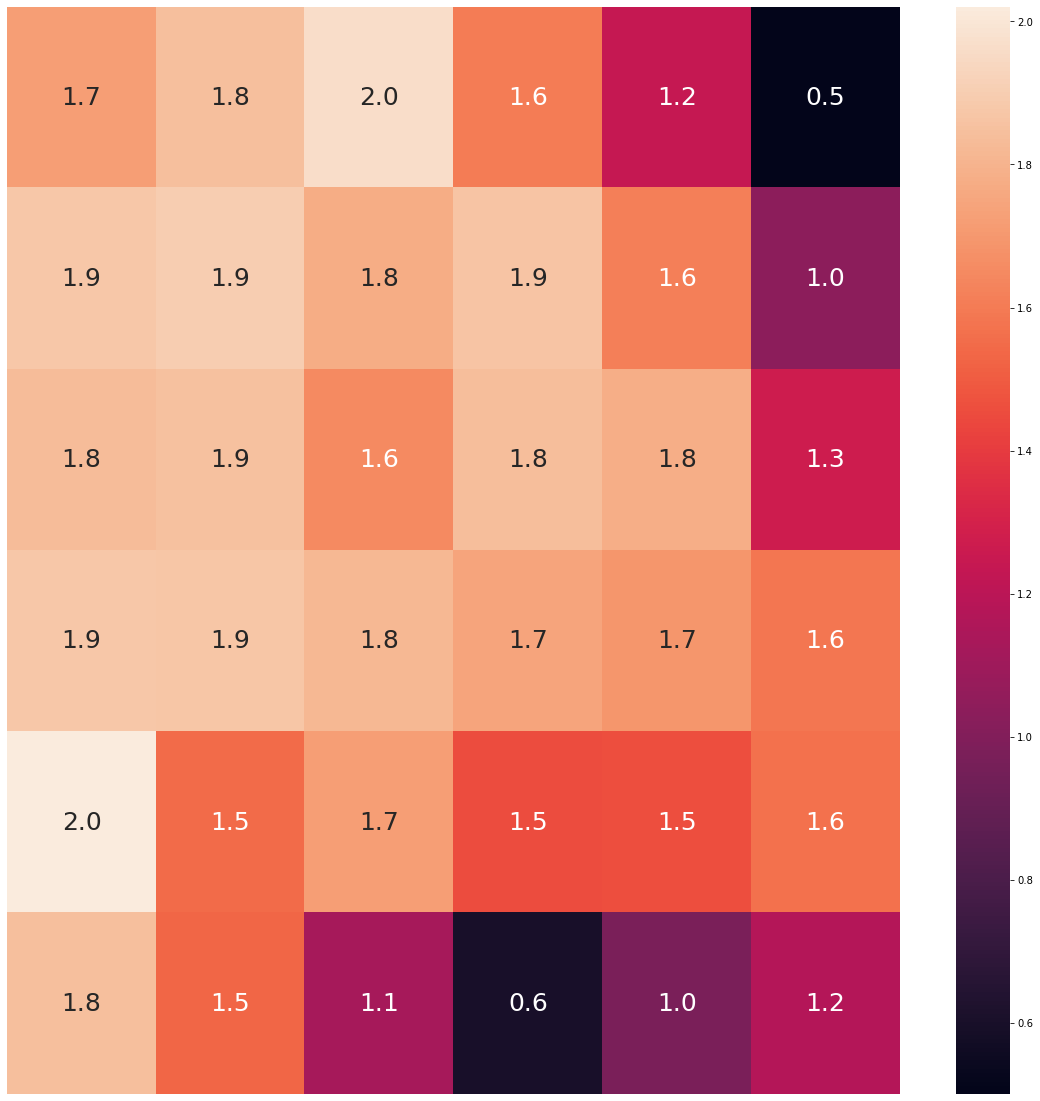

In [18]:
pyplot.figure(figsize=(20, 20))
map = sn.heatmap(r6,annot=True,fmt=".1f", annot_kws={'size':25},xticklabels=False,
                yticklabels=False)
plt.show()

In [19]:
#Absolute_median Deviation
from astropy.stats import median_absolute_deviation
n=1.4826
mr0=[]
mr1=[]
mr2=[]
mr3=[]
mr4=[]
mr5=[]
for i in range(len(r0)):
    
    a=median_absolute_deviation(np.log10(1+r0[i]))*n
    b=median_absolute_deviation(np.log10(1+r1[i]))*n
    c=median_absolute_deviation(np.log10(1+r2[i]))*n
    d=median_absolute_deviation(np.log10(1+r3[i]))*n
    e=median_absolute_deviation(np.log10(1+r4[i]))*n
    f=median_absolute_deviation(np.log10(1+r5[i]))*n
    mr0.append(a)
    mr1.append(b)
    mr2.append(c)
    mr3.append(d)
    mr4.append(e)
    mr5.append(f)
    

r6=np.array([mr0, mr1, mr2, mr3, mr4, mr5])
r6


array([[0.18912041, 0.25377853, 0.20072911, 0.23428196, 0.32273403,
        0.19955479],
       [0.26428873, 0.1855725 , 0.20808354, 0.16929032, 0.20114036,
        0.37129618],
       [0.15578361, 0.20524579, 0.24900005, 0.16719402, 0.16280766,
        0.33893006],
       [0.23018578, 0.19650074, 0.23265578, 0.20279401, 0.2044504 ,
        0.19831656],
       [0.24398521, 0.39017038, 0.19594786, 0.24676259, 0.21936202,
        0.22159446],
       [0.29071082, 0.4129276 , 0.41620999, 0.32996538, 0.31268137,
        0.1995148 ]])

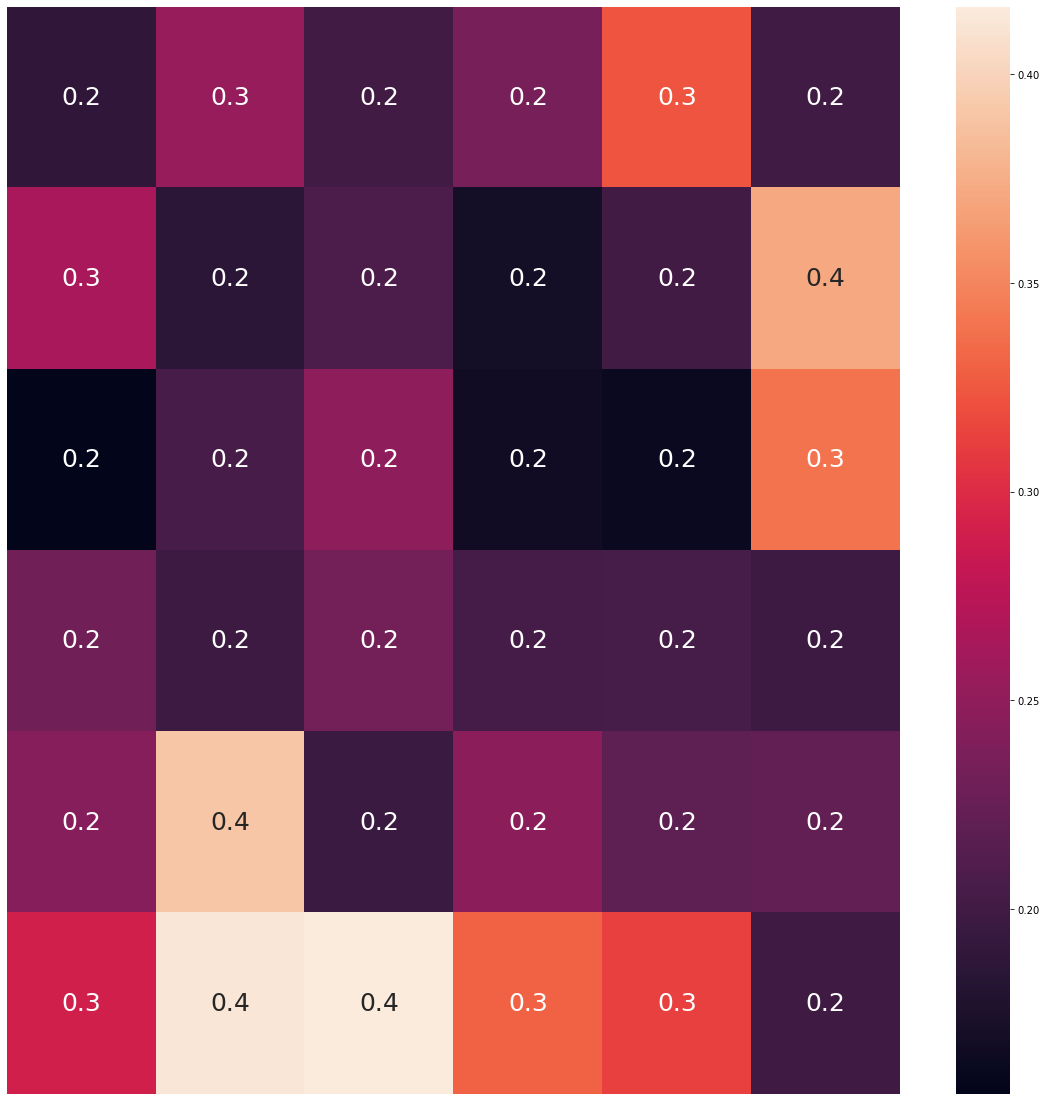

In [20]:
pyplot.figure(figsize=(20, 20))
map = sn.heatmap(r6,annot=True,fmt=".1f", annot_kws={'size':25},xticklabels=False,
                yticklabels=False)
plt.show()

In [32]:
#med+3*NMAD

from astropy.stats import median_absolute_deviation
n=1.4826
mr0=[]
mr1=[]
mr2=[]
mr3=[]
mr4=[]
mr5=[]
for i in range(len(r0)):
    
    a=median_absolute_deviation(np.log10(1+r0[i]))*n*3 + np.median(np.log10(1+r0[i]))
    
    
    
    b=median_absolute_deviation(np.log10(1+r1[i]))*n*3 + np.median(np.log10(1+r1[i]))
    c=median_absolute_deviation(np.log10(1+r2[i]))*n*3 + np.median(np.log10(1+r2[i]))
    d=median_absolute_deviation(np.log10(1+r3[i]))*n*3 + np.median(np.log10(1+r3[i]))
    e=median_absolute_deviation(np.log10(1+r4[i]))*n*3 + np.median(np.log10(1+r4[i]))
    f=median_absolute_deviation(np.log10(1+r5[i]))*n*3 + np.median(np.log10(1+r5[i]))
    mr0.append(a)
    mr1.append(b)
    mr2.append(c)
    mr3.append(d)
    mr4.append(e)
    mr5.append(f)
    

r7=np.array([mr0, mr1, mr2, mr3, mr4, mr5])
r7


array([[2.29074613, 2.60835007, 2.56678151, 2.30647964, 2.20778621,
        1.09942029],
       [2.67076443, 2.45568213, 2.39831651, 2.37421916, 2.2160102 ,
        2.15049071],
       [2.30347499, 2.46829804, 2.39580766, 2.33964544, 2.27025765,
        2.28812794],
       [2.56762554, 2.45785598, 2.51180111, 2.35433731, 2.30498616,
        2.17928637],
       [2.75268644, 2.71851833, 2.30683024, 2.19320466, 2.11931674,
        2.2327602 ],
       [2.71911279, 2.76854926, 2.3781474 , 1.59143482, 1.91140126,
        1.7718354 ]])

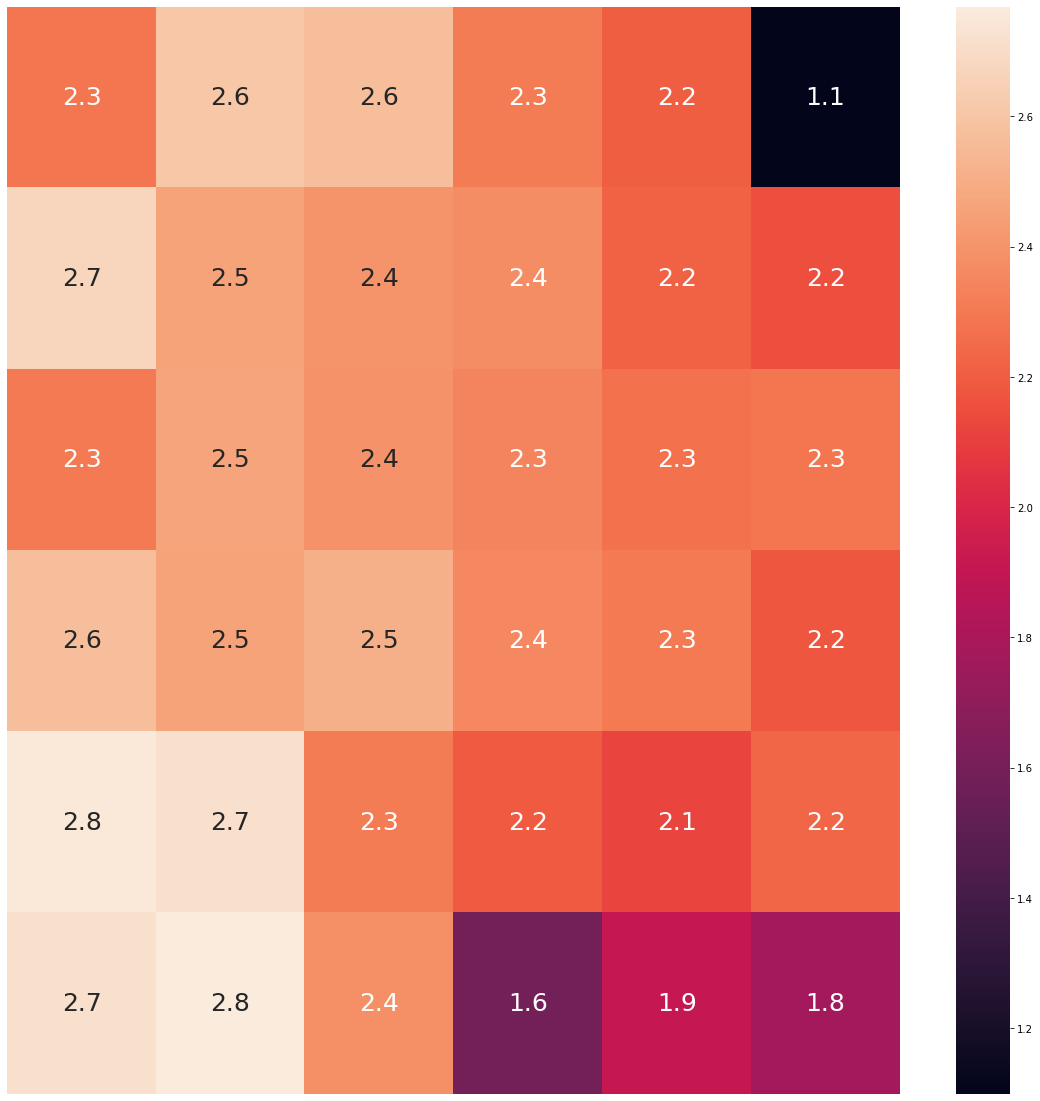

In [33]:
pyplot.figure(figsize=(20, 20))
map = sn.heatmap(r7,annot=True,fmt=".1f", annot_kws={'size':25},xticklabels=False,
                yticklabels=False)
plt.show()

In [28]:
#Plotting the Percentile
mr0=[]
mr1=[]
mr2=[]
mr3=[]
mr4=[]
mr5=[]
for i in range(len(r0)):
    
    a=np.percentile(np.log10(1+r0[i]), 99)
    b=np.percentile(np.log10(1+r1[i]),99)
    c=np.percentile(np.log10(1+r2[i]),99)
    d=np.percentile(np.log10(1+r3[i]),99)
    e=np.percentile(np.log10(1+r4[i]),99)
    f=np.percentile(np.log10(1+r5[i]),99)
    mr0.append(a)
    mr1.append(b)
    mr2.append(c)
    mr3.append(d)
    mr4.append(e)
    mr5.append(f)
    

r6=np.array([mr0, mr1, mr2, mr3, mr4, mr5])
r6

array([[2.56814138, 2.26049092, 2.72002342, 2.41693499, 1.94071908,
        1.51684017],
       [2.31261929, 2.19338502, 2.14011732, 2.20469351, 2.03579603,
        1.73870084],
       [2.38241582, 2.2639555 , 2.05115833, 2.13690779, 2.10720966,
        1.81659976],
       [2.41673225, 2.29925823, 2.21642092, 2.23859246, 2.09988418,
        1.9850761 ],
       [2.86498435, 2.13460282, 2.22249539, 2.02437766, 1.91277928,
        1.95720976],
       [2.77232845, 2.31600058, 2.06433173, 1.61969563, 1.75114253,
        1.7168106 ]])

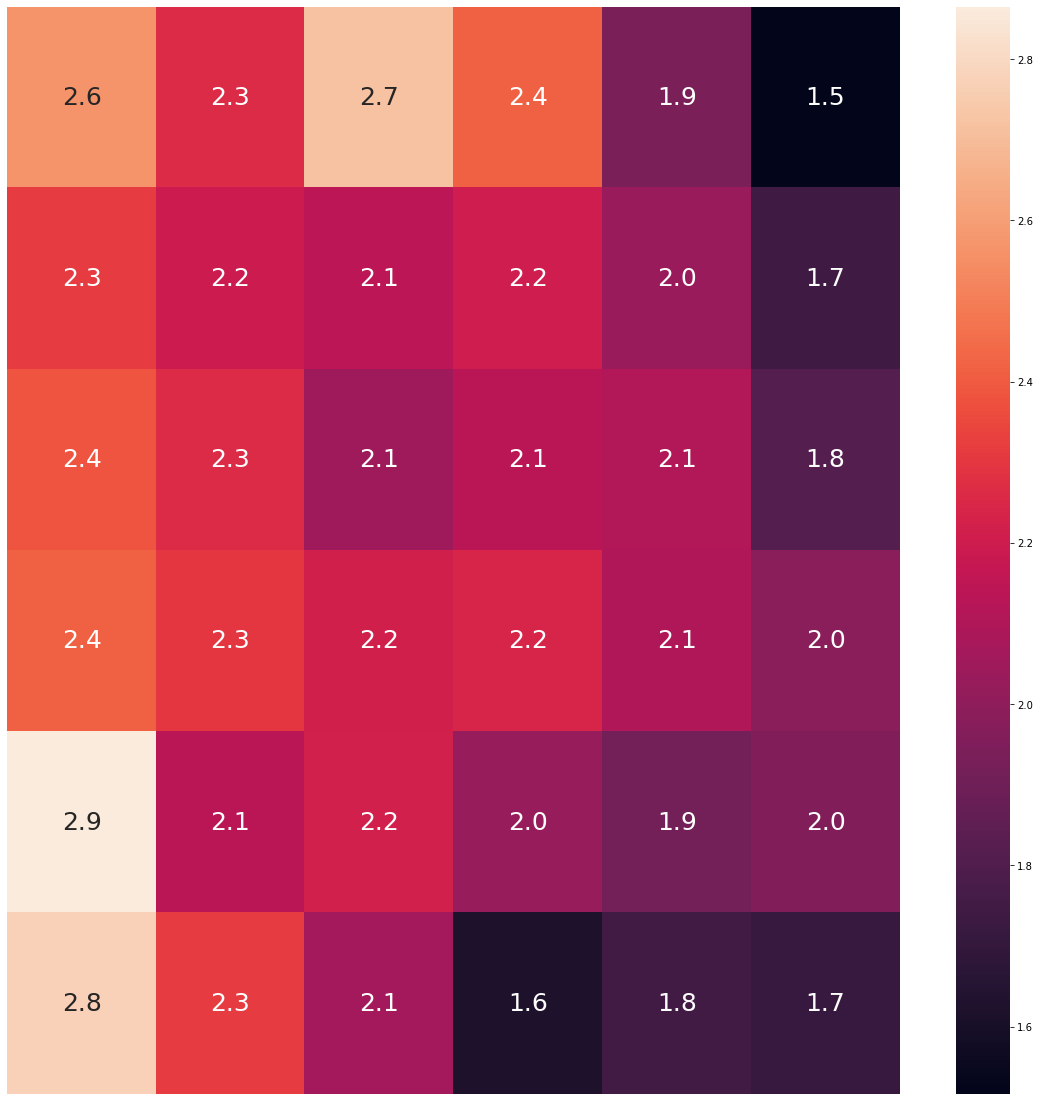

In [29]:
pyplot.figure(figsize=(20, 20))
map = sn.heatmap(r6,annot=True,fmt=".1f", annot_kws={'size':25},xticklabels=False,
                yticklabels=False)
plt.show()

In [ ]:
#####################################
# Choose prototype coordinates to investigate its most similar cut-outs
x,y,z = 1,1,0
max_number_of_images_to_show = 27
#####################################

si = (y*SOM_width)+x

# Plot the choosen prototype
proto = data_som[y,x,z,:]
proto = proto.reshape((int(s), int(s)))
pyplot.imshow(proto, aspect='equal', interpolation="nearest", origin='lower', cmap=pyplot.cm.inferno)

# Sort the euclidian distances to this prototype
closest = numpy.argsort(data_map, axis=1)[:,0]
farthest = numpy.argsort(data_map, axis=1)[:,-1]

closest_index = [i for i, som_index in enumerate(closest) if som_index == si]
closest_distances = numpy.min(data_map, axis=1)[closest_index]
sort_index = numpy.argsort(closest_distances)
closest_index = numpy.array(closest_index)[sort_index]
closest_distances = numpy.array(closest_distances)[sort_index]
farthest_index = [i for i, som_index in enumerate(farthest) if som_index == si]
print(len(closest_index), 'cut-outs are most resemblent to prototype (',x,y,').')
print(len(farthest_index), 'cut-outs are most dissimilar to prototype (',x,y,').')


# Plot cut-outs (closest to choosen prototype)
for i,id in enumerate(closest_index[:max_number_of_images_to_show]):
    # plot 182x182 image
    pyplot.figure()
    image = showOutlier(bin_file_path, id)
    image_clip = numpy.clip(image, clip_threshold*numpy.std(image), 1e10)
    #image = numpy.hstack((image, image_clip))
    pyplot.axis('off')
    pyplot.imshow(image)#, extent=[-w/2, w/2, -w/2, w/2])

    # plot border around the 128x128 center of the image
    #pyplot.plot( [(w-s)/2,w-(w-s)/2], [(w-s)/2,(w-s)/2],"r")
    #pyplot.plot( [(w-s)/2,(w-s)/2], [(w-s)/2,w-(w-s)/2],"r")
    #pyplot.plot( [w-(w-s)/2,w-(w-s)/2], [(w-s)/2,w-(w-s)/2],"r")
    #pyplot.plot( [(w-s)/2,w-(w-s)/2], [w-(w-s)/2,w-(w-s)/2],"r")
    #pyplot.title(str (coordinates[id]%somWidth) + "," + str (int(coordinates[id]/somWidth)))
    print('Distance:', closest_distances[i])
    
    pyplot.show()
